# 0 - Checking device functionality

In this section, we perform I/V measurement, in which we send voltage to electrode(s) of the device, and measure the output current. This process is done as part of the initial checks for device functionality, and it can be useful to discard devices that are not going to exhibit the desired behaviour.

**Prerequisites:**
- A device
- A measurement setup; including amplifier (I/V converter), cables, National Instruments cDAQ setup
- A complete brain-spy and brainspy-smg installation
- A complete nidaqmx-python installation
- A complete NI Driver (and software) installation  

**Read this carefully before starting with the notebook**

This notebook has created to be run on BRAINS computer. The computer should be connected to the National Instruments setup consisting of a chassis and several modules. The setup should be connected to a hardware device. If you have this or a similar setup to the one just mentioned, you should run the cells that mention: "# HARDWARE_MODE" on top of them, while avoiding to run cells that mention "# SIMULATION_MODE" on them. If you not running this test in a BRAINS computer, you should change the configurations according to how your national instruments are connected. The names of the national instruments modules can be checked on the NI MAX tool. The following values should at least be updated when in a new computer with different modules (you can jump directly to the following cell):

* "trigger_source": "cDAQ1/segment1", # This particular one makes reference to the NI Chassis allocated at cDAQ1, and the trigger source segment1. Find the different triggers you can use with your own NI module in the NI MAX tools. 
* "activation_instrument": "cDAQ1Mod3", # This refers to the module of the chassis that will be used for sending inputs to the device, in this case Mod3
* "activation channels": [0,1,2,3,4,5,6], # Typically the 7 activation electrode inputs, as connected to the national instruments setup 
* "readout_instrument": "cDAQ1Mod4", # This refers to the module of the chassis that will be used for readoung outputs from the device, in this case Mod4
* "readout_channels": [0] # Typically the single readout electrode of the device

You do NOT have access to the computers that have the National Instruments and devices connected?

If you do not have access to such a setup, but you are curious about how the code works, you should run the cells that mention: "# SIMULATION_MODE" on top of them, while avoiding to run cells that mention "# HARDWARE" on them. This will upload a processor in simulation_debug mode. For such a task, you would need to ask for a working surrogate model, that contains information from one of our devices, and it typically is named as training_data.pt. If you do not have one, you can request one to Professor Dr. Ir. Wilfred van der Wiel at  w.g.vanderwiel@utwente.nl . Note, that this **only has to be done if you do NOT have access to a computer with National Instruments and a device connected**. 

In [68]:
# HARDWARE_MODE
TRIGGER_SOURCE = 'cDAQ2'
ACTIVATION_INSTRUMENT = 'cDAQ2Mod3'
ACTIVATION_CHANNELS = [14, 7, 13, 8, 10, 11, 12] #[0,2,5,3,1,6,4]
READOUT_INSTRUMENT = 'cDAQ2Mod8'
READOUT_CHANNELS = [2]

In [69]:
# HARDWARE_MODE
info = None
model_state_dict = None

## 1. Theory

When a new device is fabricated, it needs to be wire bonded to one of the custom PCBs, that is connected to the National Instruemnt devices. Once this is ready, one of the first measurements you can perform on the "out of the oven" device to determine its quality is to check the IV curves of each electrode. This will help you to find whether if all electrodes were edged correctly and a general gist on the quality of the non-linearity. Although it is difficult to see all the input-output responses of the device, given the high dimensional inputs (typically ~7 electrodes), the IV curves will give you some information about how the device might behave. The general shape we are looking for is sort of a [logit](https://en.wikipedia.org/wiki/Logit) function. With time, you will learn to identify what shape is better for the electrodes and the task you want to solve. An important thing to take into account is the ranges in which the IV curves will operate. Shallow ranges might reduce the functionality of the device, while wide ranges might cause damage to it. Note also that the position of the electrode also determines the range in which it should operate. Activation electrodes that are closest to the readout electrodes should have a reduced range in comparison with those electrodes that are furthest away from the readout electrode. This is because closer electrodes have more influence over the otuput. There is a sweet spot where ranges are optimal for each electrode. For more information on this refer to the master thesis of Mark Boon, if you do not know where to find it, you can request it to Prof. van der Wiel at w.g.vanderwiel@utwente.nl . The following notebook will explain how you can measure a single IV curve. 

### 1.1 Electrode types in a DNPU

- Activation electrodes: These electrodes receive an input voltage (V) that will be used to obtain a non-linear output. The input range for these electrodes typically is from ~ +-1.2 V. Outside this range, the device might be damaged. In the image below, activation electrodes are electrode e0 to e6. Activation electrodes have two types:
    - Input data electrodes: The data from a particular task that wants to be resolved. For example, if the intention is to make the DNPU behave as an XOR boolean gate, two input data electrodes will be used for receiving the combination of all possible input signals (00, 01, 10, and 11) [1]. In the image below, input data electrodes are e2 and e1.
    - Control electrodes: The electrodes that set the functionality of the device for a particular task. For example, if the intention is to make the DNPU behave as an XOR boolean gate, these electrodes will set the functionality of the device in a way that it exhibits the outputs 0, 1, 1, 0, for each of the inputs 00, 01, 10, and 11, respectively. In the image below, control electrodes are e0, e3, e4, e5, and e6.
- Readout electrodes: The resulting current (nA) is measured using these electrodes. In the image below, the readout electrode is e_out.

For this task, we do NOT distinguish input or control electrodes, and we will consider them simply as activation electrodes.


The image [1] below, shows how the general scheme of a DNPU and a particular task that we will see in future.


![title](https://raw.githubusercontent.com/BraiNEdarwin/brains-py/master/doc/figures/dnpu.png)

[1] Ruiz-Euler, H. C., Alegre-Ibarra, U., van de Ven, B., Broersma, H., Bobbert, P. A., & van der Wiel, W. G. (2021). Dopant network processing units: towards efficient neural network emulators with high-capacity nanoelectronic nodes. Neuromorphic Computing and Engineering, 1(2), 024002.

## 2. Configurations for the exercise

The exercise requires the following imports:

In [70]:
import os
import torch
import matplotlib.pyplot as plt
from bspysmg.utils.iv.simple import IVMeasurement

The configurations of a task in brains-py will be described in a yaml file. This format allows to easily store/read all needed configurations in a file, as well as loading them as a configuration file for another experiment/task. 

In [71]:
configs = {} # Defining an empty list that will contain all of the default config files required for this exercise.

General configutations for I/V measurement

In [72]:
# Path to the directory if you want to save your measurement results
configs["results_based_dir"] = "tmp/"

# Boolean condition if you want to see the plots
configs["show_plots"] = True

# No. of points for the measurement; 
# How many points per each I/V curve you want to measure. 
configs["shape"] = 2000

# Configs for the input signal, which is the input voltage to the activation electrode
input_signal_configs = {
    'input_signal_type': 'sawtooth',
    'direction': 'up'
}
configs["input_signal"] = input_signal_configs

cDAQ driver configuration

In [73]:
driver_configs = {
  # Type of your NI cDAQ system
  'instrument_type': 'cdaq_to_cdaq',

  # Amplifier circuitry amplification; the calculation procedure is as follows:
  # Maximum/Minimum measured current: +158/-158 nA
  # Maximum/Minimum Op Amp. output voltage: +4/-4 V
  # Amplification equation: abs(Maximum measured current)/abs(Maximum Op. Amp output voltage)
  # Amplification: 158/4 = 39.5
  # Note that amplification value should be re-calculated for each setup seperately.
  'amplification': [39.5],

  # If your amplifier is an inverting amplifier, set the following condition to True
  'inverted_output': True,

  # Instruments setup configuration;
  # Now we configure each measurement device (e.g., DAC, ADC, and the chassis)
  'instruments_setup': {
    
  # Is your measurement for multiple devices?
  'multiple_devices': False,

  # Trigger source of the measurement (the chassis)
  # You can find this config detail in "NI MAX software", that you have previously installed together with NI driver
  'trigger_source': TRIGGER_SOURCE,

  # Oversampling, averaging the over sampled data
  'average_io_point_difference': True,
      
  # DAC update rate
  'activation_sampling_frequency': 5000,

  # ADC update rate
  'readout_sampling_frequency': 10000
  }
}

In [74]:
device_configs = {
    # DAC Module
    'activation_instrument': ACTIVATION_INSTRUMENT,

    # DAC Channels, which is connected to the device
    'activation_channels': ACTIVATION_CHANNELS,

    # Voltage ranges of the measurement in accordance to each DAC channel
    'activation_voltage_ranges':              [
           [-0.1, 0.1],
           [-0.5, 0.5],
           [-0.5, 0.5],
           [-0.5, 0.5],
           [-0.5, 0.5],
           [-0.5, 0.5],
           [-0.5, 0.5],
        ],

    # DAC channel mask, in accordance to DAC channels, setting 1 means you want to have them in your measurement,
    # Setting to 0, means you want to ignore those channels 
    'activation_channel_mask': [1,1,1,1,1,1,1],

    # ADC module
    'readout_instrument': READOUT_INSTRUMENT,

    # ADC channel, which is connected to the output of the amplifier
    'readout_channels': READOUT_CHANNELS # Analogue input channel(s) of ADC
}

Now that we have all the configs ready, we will continue with measurement code.

Note that, you do NOT need to follow each line of I/V measurement code as a user. Thus, completing the configs file properly can be considered enough to perform a valid I/V measurement.

## 3. Simple IV Curve

The simple IV curve is the easiest way to measure the current/voltage (IV) curve of an electrode, while leaving the rest of the electrodes at zero. This measurement sends a signal to a single selected activation electrode in the form of waveform or sinewave, from zero to a minimum given value, to a maximum given value, to zero again. The default configs have already been set up for a waveform. 

The simple IV curve is measured through a Processor instance. This allows to measure IV curves of surrogate models as well as direct measurements of hardware devices. Let us start by updating the default configs to configs related to the simple measurement:



In [75]:
simple_driver_configs = driver_configs.copy() # Make a copy of the default configs
simple_driver_configs['multiple_devices'] = False # Enable measurements only for a single device
simple_driver_configs['instruments_setup'].update(device_configs)# Add the declared default device configs to the simple driver configs

In [76]:
processor_configs = {
    'processor_type': 'cdaq_to_cdaq',
    'waveform': {
        'slope_length': 0,
        'plateau_length': 1
    },
    'driver': simple_driver_configs
}

----------------------------------------------------------------------------------------------------------------------------
**WARNING: Only run below cells if you want to run a surrogate model instead of a real connection to National Instruments drivers, connected to a device**

If you do not have access to National Instruments setups nor hardware devices, but you would still like to run this jupyter notebook, you can still run it on simulations. Request a surrogate model (training_data.pt) as explained in the beginning of the jupyter notebook and place it on the following folder:

In [77]:
# SIMULATION_MODE
# WARNING: Only run this cell if you want a surrogate model instead of a real connection to National Instruments drivers, connected to a device
folder_path = os.path.join(os.getcwd(),'surrogate_model')
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
print("Place the training_data.pt file you received into: "+folder_path)

Place the training_data.pt file you received into: C:\Users\Unai\Documents\programming\brainspy-examples\surrogate_model


Once you have placed the data in the mentioned folder, you can load the data into model_data

In [78]:
# SIMULATION_MODE
# WARNING: Only run this cell if you want a surrogate model instead of a real connection to National Instruments drivers, connected to a device
model_data = torch.load(os.path.join(folder_path,'training_data.pt'))
info = model_data['info']
model_state_dict = model_data['model_state_dict']

Then you can update the same configs to be in simulation as follows:

In [79]:
# SIMULATION_MODE
# WARNING: Only run this cell if you want a surrogate model instead of a real connection to National Instruments drivers, connected to a device
processor_configs['processor_type'] = 'simulation_debug'

**WARNING: Only run above cells if you want to run a surrogate model instead of a real connection to National Instruments drivers, connected to a device**

----------------------------------------------------------------------------------------------------------------------------

Once the driver configs for a simple IV curve measurements are ready, the configs of a processor are declared. Run the following configs if you are on a hardware setup:

In [80]:
measurement = IVMeasurement(processor_configs, info=info, model_state_dict=model_state_dict)

c:\users\unai\documents\programming\brains-py\brainspy\processors\simulation\noise\noise.py:97: UserWarning: No noise is being simulated for the model.
  warnings.warn("No noise is being simulated for the model.")
c:\users\unai\documents\programming\brains-py\brainspy\utils\waveform.py:78: UserWarning: Slope Length is 0
  warnings.warn("Slope Length is 0")


With the processor configs ready, an IVMeasurement class can be instantiated as follows:

The IVMeasurement instance is ready to be used for measuring any electrode. For this, we need to specify the maximum and minimum values to which the measurement will be done. Let us take these minimum and maximum values from what is defined in the configs. 

In [81]:
min_val = measurement.driver.get_voltage_ranges()[0, 0].item()
max_val = measurement.driver.get_voltage_ranges()[0, 1].item()


print("Min Value: {:.2f}".format(min_val))
print("Max Value: {:.2f}".format(max_val))

Min Value: -1.30
Max Value: 0.50


Let us perform a measurement of 1000 points in total on activation electrode 0

In [82]:
inputs, outputs = measurement.iv_curve(min_val, max_val, point_no=1000, input_electrode=0, close=False)

This measurement returns the inputs and the outpus in numpy format, so that the user can handle them freely. Note that by default, the iv_curve measurement closes the driver after a measurement. However, the option close=False could be set, in order to let the driver open, and perform other measurements in other IV curves. This allows the user to perform different measurements in different electrodes and save them all. Then, it is important that the last measruement closes the driver with the flag close=True, to avoid resource allocation issues. An example of using a for loop for plotting all IV curves can be found in https://github.com/BraiNEdarwin/brainspy-smg/wiki/E-.-Usage-examples . A simpler example, to plot the outputs and inputs could be as follows:

Text(0.5, 1.0, 'I\\V curve')

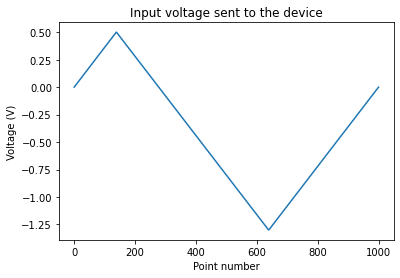

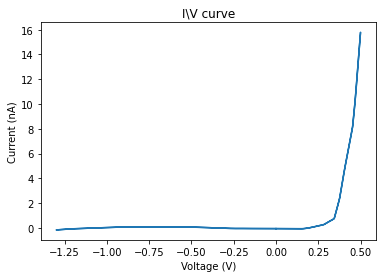

In [83]:
plt.figure()
plt.plot(inputs, label='Inputs (V)')
plt.xlabel('Point number')
plt.ylabel('Voltage (V)')
plt.title('Input voltage sent to the device')
plt.figure()
plt.plot(inputs, outputs)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (nA)')
plt.title('I\V curve')

The min_val and max_val will determine the range of the IV curve. You can play on changing these values when calling the function iv_curve in order to find the optimal range. 

This notebook has covered how you can measure a simple IV curve. In order to speed up the process of finding useful devices, brainspy-smg also supports measuring the IV curves of all the activation electrodes of a device simultaneously, using the bspysmg.utils.iv.multiple.MultiIVMeasurement class. A template on the configurations needed for this is provided in brainspy-smg/configs/utils/brains_ivcurve_template.yaml. Finally, in order to speed up the process of finding useful devices, you can also measure using the MultiIVMeasurement class on up to 5 devices at the same time, provided these are connected to the 5 device PCB. Check the wiki of brainspy-smg to find an example on how to use the MultiIVMeasurement class.